<div align="center">
    <h2> SEGUNDO RECURSO
    <h5>Una animación de la órbita del cometa Halley
    <h5>Temática: solución problema de los dos cuerpos
</div>

<blockquote>
Universidad de Antioquia. <br>
Facultad de Ciencias Exactas y Naturales. <br>
<b>Advertencia</b>: recursos creados como parte del desarrollo del curso mecánica celeste (0311602) del pregrado de astronomía de la Universidad de Antioquia, bajo la dirección del profesor Jorge Zuluaga.
</blockquote>

## Algunos conceptos importantes

Este proyecto permite al usuario simular/estudiar las trayectorias de 2 objetos del sistema solar. El primero de ellos es la órbita en el tiempo del cometa Halley y la segunda es el análisis de la órbita del asteroide 7482 (1994 PC1), un PHA (potentially hazardous astroid). 

Se pretende ver el efecto de las perturbaciones gravitacionales entre objetos del sistema solar: **asteroide 7482 -  tierra** y **cometa Halley - sol** utilizando cálculos astrodinámicos fundamentales.

### ¿Elementos orbitales?

A partir de las ecuaciones paramétricas de la cónica en su plano natural: 

\begin{eqnarray}
\nonumber
x''' & = & \frac{p\cos f}{1+e\cos f}\\
\nonumber
y''' & = & \frac{p\sin f}{1+e\cos f}\\
\nonumber
z''' & = & 0
\end{eqnarray}

Se pueden escribir las ecuaciones paramétricas generales de una cónica en el espacio como:

\begin{equation}
\label{eq:elementos_estado_f}
\begin{array}{rcl}
x & = & r[\cos \Omega \cos(\omega+f) - \cos i \sin \Omega \sin(\omega+f)]\\
y & = & r[\sin \Omega \cos(\omega+f) + \cos i \cos \Omega \sin(\omega+f)]\\
z & = & r[\cos f\sin \omega \sin i + \sin f \cos \omega \sin i]\\ 
\end{array}
\end{equation}

donde $r=p/(1+e\cos f)$

Así para específicar la posición de cualquier punto sobre una cónica (órbita), independiente de su orientación espacial, hace falta indicar el valor de 6 parámetros: $p , e, i, Ω, ω$ y $f$.  Cantidades llamadas en mecánica celeste los elementos orbitales clásicos.
### Halley 
Para el cometa halley en este notebook se obtendran los datos y kernels de SPICE, a través de la biblioteca spiceypy, desarrollada en Python por el JPL (Jet Propulsion Laboratory) de la NASA.
### Asteroide 7482
También, en este notebook se obtendran los elementos orbitales (a,e,I,𝛺,𝜔,M) del asteroide 7482 en la fecha 2022-Jan-18 21:51 con respecto al Sol usando **astroquery**. Con estos elementos se convierte al vector de estado, usando:

$$
\left(\begin{array}{cc} 
x''' \\
y'''\\
z'''
\end{array}\right)=R_z(w)R_x(i)R_z(Ω)
\left(\begin{array}{cc} 
x\\ 
y\\
z
\end{array}\right)
$$ 

Para las posiciones y velocidades se usa:

\begin{equation}
x=rcos(f) , y=rsin(f) \\
v_x=-\frac{\mu}{h}sin(f),\\
v_y=\frac{μ}{h}(e+cos(f))
\end{equation}

Con esto se usa la matriz inversa $M(w,i,Ω)^{-1}$  para encontrar los valores de posición y velocidad finales en cierto tiempo dado. Usando los datos del asteroide y de la tierra, se puede saber la distancia de la Tierra al asteroide. 

Con los valores encontrados por un año en el pasado y futuro se compara con los valores de Horizons, así se ecuentran los errores para cada epoca.

## Paquetes y librerias necesarias para el reto

In [1]:
!python -m pip install spiceypy &> /dev/null
!python -m pip install matplotlib &> /dev/null
!python -m pip install seaborn &> /dev/null
!python -m pip install astroquery &> /dev/null
import sys
import json
import base64
import requests
import spiceypy as spy
import numpy as np
import matplotlib.pyplot as plt
import itertools 
import pandas as pd
import astropy.units as u
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from spiceypy.spiceypy import str2et

Bajar los archivos necesarios de SPICE (https://naif.jpl.nasa.gov/pub/naif/generic_kernels/):

In [2]:
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls &> /dev/null
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de435.bsp &> /dev/null
!wget https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/gm_de431.tpc  &> /dev/null
#--------------------------------------------
#-- kernel data cometa halley de Giotto  ----
#--------------------------------------------
!wget https://naif.jpl.nasa.gov/pub/naif/GIOTTO/kernels/spk/giotto_19860305_19860317.bsp &> /dev/null

In [3]:
#-----------------------------------------------------------------------------
# --     Se descarga 1000036.bsp con la api de Horizons             ----------
# -- construida con el ejemplo alojado en la página web del JPL     ----------
#-----------------------------------------------------------------------------
spk_filename = 'spk_file.bsp'
url = "https://ssd.jpl.nasa.gov/api/horizons.api?format=json&COMMAND='90000033'&OBJ_DATA='NO'&MAKE_EPHEM='YES'&EPHEM_TYPE='SPK'&CENTER='500@0'&START_TIME='1986-01-01'&STOP_TIME='2200-01-01'"
response = requests.get(url)
try:
  data = json.loads(response.text)
except ValueError:
  print("Unable to decode JSON results")

# If the request was valid...  
if (response.status_code == 200):
  # If the SPK file was generated, decode it and write it to the output file: -
  if "spk" in data:
    # If a suggested SPK file basename was provided, use it:  
    if "spk_file_id" in data:
      spk_filename = data["spk_file_id"] + ".bsp"
    try:
      f = open(spk_filename, "wb")
    except OSError as err:
      print("Unable to open SPK file '{0}': {1}".format(spk_filename, err))
    # Decode and write the binary SPK file content: -
    f.write(base64.b64decode(data["spk"]))
    f.close()
    print("wrote SPK content to {0}".format(spk_filename))
    #sys.exit()
    
#-----------------------------------------------------------------------------
# -  Alternativa descarar el archivo y alojarlo en drive  --------------------
# -    se descragó el archivo bsp  del cometa halley      --------------------
#-----------------------------------------------------------------------------
#!cp '/content/drive/MyDrive/UdeA/2021/2021-2/Mecánica Celeste - propio/1000036.bsp' '1000036.bsp'

wrote SPK content to 1000025.bsp


In [4]:
#-------------------------------------------------------
#- leer los archivos / Cargar uno o más núcleos SPICE  -
#-------------------------------------------------------
spy.furnsh(["naif0012.tls","de435.bsp","gm_de431.tpc",'giotto_19860305_19860317.bsp', '1000036.bsp'])

## Parte 1

Usando las herramientas vistas en clase, realice una animación de la órbita del cometa Halley a lo largo de una órbita.


Condiciones:
- La animación debe parecerse tanto como sea posible al gif animado adjunto.
- La animación debe mostrar en cada paso la fecha de cada fotograma.

Entregable: 
- Archivo de la animación en formato MP4 o GIF animado.
- Notebook de Colaboratory.
- El notebook debe correr completamente y sin errores en Colaboratory.

Imagen de **ejemplo**:

<img src = "https://drive.google.com/uc?export=view&id=14GDzJ2XA6VeJVctZVOVGjFXCncDTK1tX" width = "390" height = "370" alt = "ejemplo" align = "center" />


In [5]:
#--------------------------------------------
#-- Intervalo de tiempo   -------------------
#--------------------------------------------
ephemeris_time_initial = spy.str2et("1986-02-02 00:00:00 UTC-5")

ephemeris_time_final = spy.str2et("2149-07-28 04:00:00 UTC-5")

time = np.linspace(ephemeris_time_initial,ephemeris_time_final,1300)

In [6]:
def et2str(et):
    "Convert an ephemeris time (seconds after J2000) to a UTC string."
    formatStr = "C"
    prec = 0
    s = spy.et2utc(et, formatStr, prec, lenout=256)
    return s

In [7]:
tabla_positions=pd.DataFrame()
id_list=[
    'Mercury Barycenter',
    'Venus Barycenter',
    'Earth-Moon Barycenter',
    'Mars Barycenter',
    'Jupiter Barycenter',
    'Saturn Barycenter',
    'Uranus Barycenter',
    'Neptune Barycenter',
    'HALLEY']

In [8]:
for i in range(0,9):
  positions, lightTimes = spy.spkpos(id_list[i], time, 'J2000', 'none', 'SUN')
  positions1 = np.asarray(positions).T 
  tabla_positions[f'x_{i}']=positions1[0]
  tabla_positions[f'y_{i}']=positions1[1]


In [9]:
#--------------------------------------------
#--  Animación    --------------------------- 
#--------------------------------------------
n_points = 1300
plt.style.use('dark_background')

figure, ax = plt.subplots(figsize=(8, 9))
ax = plt.axes(xlim=(-3.4*1e9, 3.4*1e9), ylim=(-3.4*1e9, 4.2*1e9))

#Label que me trae la función y me muestra el texto
label = ax.text(0, 4*1e9, et2str(time[0]), ha='center', va='center', fontsize=12)

mercurio, = ax.plot([], [], color='silver', marker='.', markersize=9)
venus, = ax.plot([], [],  color='limegreen', marker='.', markersize=10)
tierra, = ax.plot([], [], 'b.', markersize=11)
marte, = ax.plot([], [], 'r.', markersize=12)
jupiter, = ax.plot([], [], 'm.', markersize=15)
saturno, = ax.plot([], [], 'y.', markersize=15)
urano, = ax.plot([], [], 'c.', markersize=15)
neptuno, = ax.plot([], [], 'b.', markersize=15)
halley, = ax.plot([], [], 'w.', markersize=13)

ax.plot(0, 0, 'X', markersize=5, color="yellow")
ax.set_axis_off()

for i in range(9):
  x = tabla_positions[f'x_{i}']
  y = tabla_positions[f'y_{i}']
  plt.plot(x,y, linewidth=0.7, alpha=0.3);


def animate(i):
    label.set_text(et2str(time[i]))
    mercurio.set_data(tabla_positions['x_0'][i], tabla_positions['y_0'][i])
    venus.set_data(tabla_positions['x_1'][i], tabla_positions['y_1'][i])
    tierra.set_data(tabla_positions['x_2'][i], tabla_positions['y_2'][i])
    marte.set_data(tabla_positions['x_3'][i], tabla_positions['y_3'][i])
    jupiter.set_data(tabla_positions['x_4'][i], tabla_positions['y_4'][i])
    saturno.set_data(tabla_positions['x_5'][i], tabla_positions['y_5'][i])
    urano.set_data(tabla_positions['x_6'][i], tabla_positions['y_6'][i])
    neptuno.set_data(tabla_positions['x_7'][i], tabla_positions['y_7'][i])
    halley.set_data(tabla_positions['x_8'][i], tabla_positions['y_8'][i])
    return mercurio,venus, tierra,marte, jupiter, saturno,urano

plt.close(figure)
anim = FuncAnimation(figure, animate, frames=590, interval=50)
from IPython.display import HTML
HTML(anim.to_html5_video())

## Parte 2


+ Obtener con Astroquery los elementos orbitales del asteroide en la fecha 2022-Jan-18 21:51 con respecto al Sol.

In [10]:
#--------------------------------------------
#-- Se obtienen elementos orbitales ---------
#--------------------------------------------
orbital_elements=Horizons(id= '1994 PC1'  ,location="@sun",epochs={'2022-Jan-18 21:51'}).elements()  

#Elementos
grados=np.pi/180
rad=180/np.pi
peri=orbital_elements['w']
i=orbital_elements['incl']
node=orbital_elements['Omega']
t=Time("2022-1-18 21:51:00").jd
n=orbital_elements['n'] #deg/d
e=orbital_elements['e']
a=orbital_elements['a'] #AU
tp=orbital_elements['Tp_jd']
M=n*(t-tp)

#Matriz con elementos
Mrot=spy.eul2m(peri*np.pi/180,np.deg2rad(i),node*grados,3,1,3)
#Matriz con elementos invertida
Minv=spy.invert(Mrot)

#Rutina para encontrar E
def solucion_kepler_newton(e,M,tol):
  E=M
  Em=E+100*tol
  while abs(E-Em)>=tol:
    Em=E
    E=E-(E-e*np.sin(E)-M)/(1-e*np.cos(E))
  return E

#Asiganción a cada variable
E=solucion_kepler_newton(e,M*grados,1e-11)
f=2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))
p=a*(1-e**2)
r=p/(1+e*np.cos(f))

#Posiciones
xp=r*np.cos(f)
yp=r*np.sin(f)
zp=0

mu=(n*grados)**2*a**3
h=np.sqrt(mu*p)

vxp=-mu/h*np.sin(f)
vyp=mu/h*(e+np.cos(f))
vzp=0

r=spy.mxv(Minv,[xp,yp,zp])
v=spy.mxv(Minv,[vxp,vyp,vzp])

h1=Horizons(id= '1994 PC1'  ,location="@sun",epochs=t).vectors()  
H=h1['x'],h1['y'], h1['z']
V=h1['vx'],h1['vy'], h1['vz']

#almacenamiento de datos en un dataframe
dp=pd.DataFrame({'Datos de posición [AU]':r, 'Horizons [AU]':H})
dv=pd.DataFrame({'Datos de velocidad [AU/d]':v, 'Horizons [AU/d]':V})


+ Obtener con Astroquery los elementos orbitales de la tierra en la fecha 2022-Jan-18 21:51 con respecto al Sol. Y encuentre la distancia en km a la que estaba el asteroide ese día y a esa hora respecto de nuestro planeta. Un asteroide se considera un PHA si su distancia a la Tierra es < 0.05 au.

In [11]:
#--------------------------------------------
#-- Se obtienen elementos orbitales ---------
#--------------------------------------------
orbital_elements_earth=Horizons(id= 399  ,location="@sun",epochs={'2022-Jan-18 21:51'}).elements()  

#Elementos
peri=orbital_elements_earth['w']
i=orbital_elements_earth['incl']
node=orbital_elements_earth['Omega']
t=Time("2022-1-18 21:51:00").jd
n=orbital_elements_earth['n'] #deg/d
e=orbital_elements_earth['e']
a=orbital_elements_earth['a'] #AU
tp=orbital_elements_earth['Tp_jd']
M=n*(t-tp)

#Matriz con elementos
Mrot=spy.eul2m(peri*np.pi/180,np.deg2rad(i),node*grados,3,1,3)
#Matriz con elementos invertida
Minv=spy.invert(Mrot)

E=solucion_kepler_newton(e,M*grados,1e-11)
f=2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))

p=a*(1-e**2)
r=p/(1+e*np.cos(f))

#Posiciones
xpt=r*np.cos(f)
ypt=r*np.sin(f)
zpt=0

mu=(n*grados)**2*a**3
h=np.sqrt(mu*p)
vxpt=-mu/h*np.sin(f)
vypt=mu/h*(e+np.cos(f))
vzpt=0

rt=spy.mxv(Minv,[xpt,ypt,zpt])
vt=spy.mxv(Minv,[vxpt,vypt,vzpt])
h1t=Horizons(id= 399  ,location="@sun",epochs=t).vectors()  
Ht=h1t['x'],h1t['y'], h1t['z']
Vt=h1t['vx'],h1t['vy'], h1t['vz']

#almacenamiento de datos en un dataframe
dpt=pd.DataFrame({'Datos de posición [AU]':rt, 'Horizons [AU]':Ht})
dvt=pd.DataFrame({'Datos de velocidad [AU/d]':vt, 'Horizons [AU/d]':Vt})

In [12]:
#distancia entre la tierra y el asteroide
UA=150e+6 #km 
distancia=spy.vnorm(np.array(dpt['Datos de posición [AU]'])-np.array(dp['Datos de posición [AU]']))

In [13]:
print( f'El asteroide se encontraba en esa fecha a {distancia:.3f} AU respecto de la tierra')

El asteroide se encontraba en esa fecha a 0.013 AU respecto de la tierra


In [14]:
print(f'El asteroide se encontraba en esa fecha a {(distancia*UA):e} Km respecto de la tierra')

El asteroide se encontraba en esa fecha a 1.986800e+06 Km respecto de la tierra


+ El valor encontrado es 0.01 UA < 0.05 UA, el asteroide se considera PHA. En esa fecha se encontraba a 1.98 millones de km de la Tierra.

### Análisis 
Calcule las posiciones y velocidades del asteroide 1 año en el pasado y año en el futuro, usando los métodos vistos en el curso (paso de tiempo de 6 horas), es decir usando la teoría del problema de los dos cuerpos.  Compare las posiciones y velocidades calculadas con aquellas provistas en las mismas fechas y horas por Horizons que usa un integrador de N cuerpos para resolver el problema.  Haga una gráfica del error relativo en la posición (valor absoluto de la distancia del asteroide real al asteroide teórico dividido la distancia al sol del asteroide real) y de la velocidad, como función del tiempo, antes y después del paso cercano.

In [15]:
#--------------------------------------------
#-- Análisis un año en el pasado    ---------
#--------------------------------------------
orbital_elements=Horizons(id= '1994 PC1'  ,location="@sun",epochs={'2022-Jan-18 21:51'}).elements()  

#Elementos
grados=np.pi/180
rad=180/np.pi
peri=orbital_elements['w']
i=orbital_elements['incl']
node=orbital_elements['Omega']
t=Time("2022-1-18 21:51:00").jd
n=orbital_elements['n'] #deg/d
e=orbital_elements['e']
a=orbital_elements['a'] #AU
tp=orbital_elements['Tp_jd']
M=n*(t-tp)

#Matriz con elementos
Mrot=spy.eul2m(peri*np.pi/180,np.deg2rad(i),node*grados,3,1,3)
#Matriz con elementos invertida
Minv=spy.invert(Mrot)

#Rutina para encontrar los tiempos de un año en el pasado por intervalos de 6 horas o cada 0.25 jd.
j=[]
t=0
tif=[Time("2021-1-18 21:51:00").jd,Time("2022-1-18 21:51:00").jd]
tt=int(8760/6)
for i in range(0,tt+1):
    t=Time("2022-1-18 21:51:00").jd-0.25*i
    j+=[t]
    

#Rutina para encontrar las posiciones y velocidades usando los tiempos anteriores
Rp=[]
Vp=[]
for i in range(0,len(j)):
  t=j[i]
  M=n*(t-tp)

  E=solucion_kepler_newton(e,M*grados,1e-11)
  f=2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))

  p=a*(1-e**2)
  r=p/(1+e*np.cos(f))

  x=r*np.cos(f)
  y=r*np.sin(f)
  z=0

  mu=(n*grados)**2*a**3
  h=np.sqrt(mu*p)
  vx=-mu/h*np.sin(f)
  vy=mu/h*(e+np.cos(f))
  vz=0

  r=spy.mxv(Minv,[x,y,z])
  v=spy.mxv(Minv,[vx,vy,vz])
  Rp+=[r]
  Vp+=[v]

#Datos por un año en el pasado calculadas
data_past=pd.DataFrame({'Tiempo_jd':j, 'Posiciones(x,y,z) [AU]':Rp, 'Velocidades(vx,vy,vz) [AU/d]':Vp})

#Datos por un año en el pasado dadas por horizons
horizons_data=Horizons(id= '1994 PC1'  ,location="@sun",epochs={'start':'2021-Jan-18 21:51', 'stop':'2022-Jan-18 21:51','step':'6h'}).vectors() 

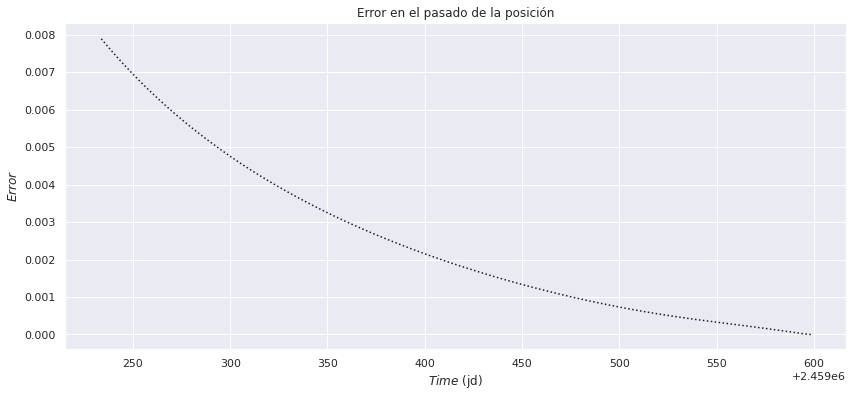

In [16]:
#Asignación para calculo de los errores en las posiciones de un año en el pasado.
posiciones_calculadas=np.array(data_past['Posiciones(x,y,z) [AU]'])

lista_horizons=[np.array([horizons_data['x'][i],horizons_data['y'][i],horizons_data['z'][i]]) for i in range(0,len(horizons_data['x']))]
posiciones_horizons=lista_horizons[::-1]

t=np.array(data_past['Tiempo_jd'])
errorj=np.array([spy.vnorm(posiciones_calculadas[i]-posiciones_horizons[i])/spy.vnorm(posiciones_horizons[i]) for i in range(0,len(posiciones_horizons))])

import seaborn as sns
sns.set()

plt.figure(figsize=(14,6))
plt.title('Error en el pasado de la posición')
plt.plot(t,errorj,'k:')
plt.xlabel("$Time$ (jd)");
plt.ylabel("$Error$");

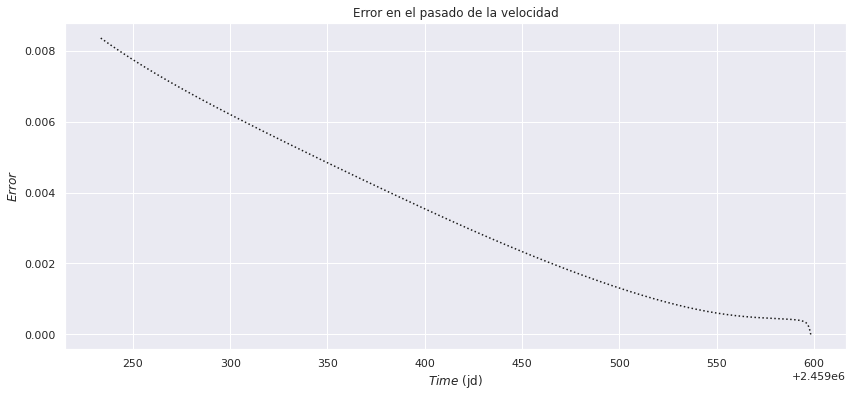

In [17]:
velocidades_calculadas=np.array(data_past['Velocidades(vx,vy,vz) [AU/d]'])

lista_horizons_v=[np.array([horizons_data['vx'][i],horizons_data['vy'][i],horizons_data['vz'][i]]) for i in range(0,len(horizons_data['vx']))]
velocidades_horizons=lista_horizons_v[::-1]

t=np.array(data_past['Tiempo_jd'])
error_v=np.array([spy.vnorm(velocidades_calculadas[i]-velocidades_horizons[i])/spy.vnorm(velocidades_horizons[i]) for i in range(0,len(velocidades_horizons))])

plt.figure(figsize=(14,6))
plt.title('Error en el pasado de la velocidad')
plt.plot(t,error_v,'k:')
plt.xlabel("$Time$ (jd)");
plt.ylabel("$Error$");

In [18]:
#--------------------------------------------
#-- Análisis un año en el futuro   ---------
#--------------------------------------------
k=[]
t=0
tif=[Time("2022-1-18 21:51:00").jd,Time("2023-1-18 21:51:00").jd]
tt=int(8760/6)
for i in range(0,tt+1):
    t=Time("2022-1-18 21:51:00").jd+0.25*i
    k+=[t]
    
R=[]
V=[]
for i in range(0,len(k)):
  t=k[i]
  M=n*(t-tp)

  E=solucion_kepler_newton(e,M*grados,1e-11)
  f=2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(E/2))

  p=a*(1-e**2)
  r=p/(1+e*np.cos(f))

  x=r*np.cos(f)
  y=r*np.sin(f)
  z=0

  mu=(n*grados)**2*a**3
  h=np.sqrt(mu*p)
  vx=-mu/h*np.sin(f)
  vy=mu/h*(e+np.cos(f))
  vz=0

  r=spy.mxv(Minv,[x,y,z])
  v=spy.mxv(Minv,[vx,vy,vz])
  R+=[r]
  V+=[v]

#Datos por un año en el futuro calculadas
data_future=pd.DataFrame({'Tiempo_jd':k, 'Posiciones(x,y,z) [AU]':R, 'Velocidades(vx,vy,vz) [AU/d]':V})

#Datos por un año en el futuro dadas por horizons
horizons_data_future=Horizons(id= '1994 PC1'  ,location="@sun",epochs={'start':'2022-Jan-18 21:51', 'stop':'2023-Jan-18 21:51',
                       'step':'6h'}).vectors()  

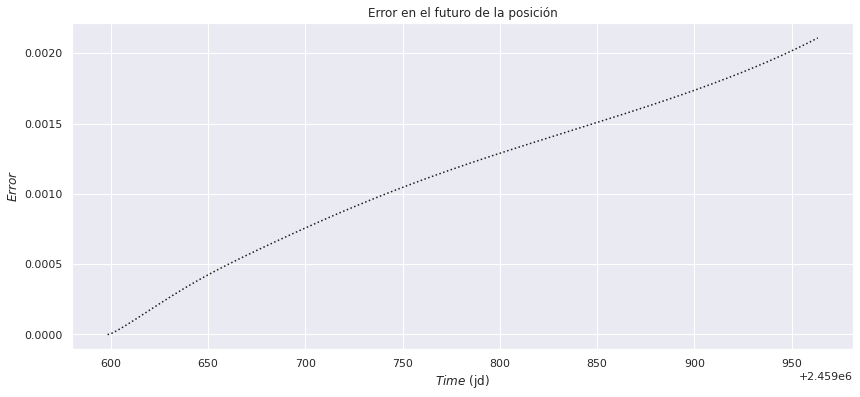

In [19]:
posiciones_calculadas_f=np.array(data_future['Posiciones(x,y,z) [AU]'])
lista_horizons_f=[np.array([horizons_data_future['x'][i],horizons_data_future['y'][i],horizons_data_future['z'][i]]) for i in range(0,len(horizons_data_future['x']))]
t=np.array(data_future['Tiempo_jd'])
error_future=np.array([spy.vnorm(posiciones_calculadas_f[i]-lista_horizons_f[i])/spy.vnorm(lista_horizons_f[i]) for i in range(0,len(lista_horizons_f))])

plt.figure(figsize=(14,6))
plt.title('Error en el futuro de la posición')
plt.plot(t,error_future,'k:')
plt.xlabel("$Time$ (jd)");
plt.ylabel("$Error$");

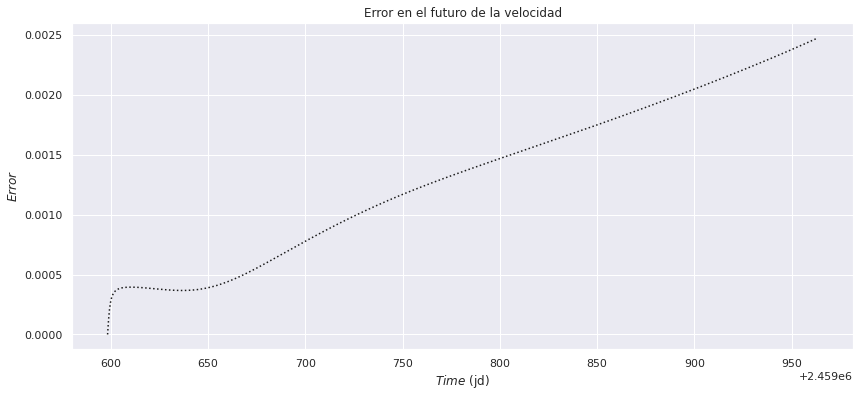

In [20]:
velocidades_calculadas_f=np.array(data_future['Velocidades(vx,vy,vz) [AU/d]'])

lista_horizons_f_v=[np.array([horizons_data_future['vx'][i],horizons_data_future['vy'][i],horizons_data_future['vz'][i]]) for i in range(0,len(horizons_data_future['vx']))]
error_velocidad_f=np.array([spy.vnorm(velocidades_calculadas_f[i]-lista_horizons_f_v[i])/spy.vnorm(lista_horizons_f_v[i]) for i in range(0,len(lista_horizons_f_v))])

plt.figure(figsize=(14,6))
plt.title('Error en el futuro de la velocidad')
plt.plot(t,error_velocidad_f,'k:')
plt.xlabel("$Time$ (jd)");
plt.ylabel("$Error$");

### Conclusiones
Presente sus  conclusiones de este experimento numérico.

Lo que se puede concluir del experimento, al ver las gráficas de los errores  es que el método utilizado en clase deducido a partir del problema de los dos cuerpos aplica para este tipo de objetos y se acercan a la realidad con una presición aceptable que solo se ve afectada en este caso al aumentar el tiempo de iteración, también se nota que en las posiciones el error en el pasado decrece y en el fututo aumenta.

Hay presentes en las gráficas unas curvas que aumentan el error en algunos sectores, estos  podrían ser ocasionado por 'tirones' gravitacionales de Júpiter que no se están teniendo en cuenta.